__Zillow housing data:__

goal- determine the 5 best zip codes to invest in using predictive modeling with time series



# imports, functions

In [1]:
# import libraries and tools
import warnings
warnings.filterwarnings('ignore')
import numpy as np, pandas as pd
import pandas_profiling
import datetime
from pandas import read_csv
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import itertools
import pmdarima as pm
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from numpy import log
from pandas.plotting import autocorrelation_plot
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from itertools import product
from tqdm import tqdm_notebook
from math import sqrt

# from pylab import rcParams
# rcParams['figure.figsize'] = 18, 8

from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
# import matplotlib
import matplotlib.dates as mdates

In [2]:
# amount of times value increases    
def get_increasing_count(df):
    is_dec = df.diff().lt(0).values
    cnt = 265
    #starting_value = df.values[0]
    #result = []
    for i in range(len(is_dec)):
        if is_dec[i]:
            cnt -= 1
    return cnt

In [150]:
#time series, ACF, PACF, and dist plot
def plot_data_properties(data, lags=12):

    plt.figure(figsize=(16,4))
    plt.plot(data)
    plt.title("Time Series Plot")
    plt.ylabel('Value')
    plt.xlabel('Year')
    fig, axes = plt.subplots(1,3,squeeze=False)
    fig.set_size_inches(16,4)
    plot_acf(data, ax=axes[0,0], lags=lags);
    plot_pacf(data, ax=axes[0,1], lags=lags);
    sns.distplot(data, ax=axes[0,2])
    axes[0,2].set_title("Probability Distribution")

In [51]:
# seasonal decomposition
def seas_decomp(zip_code):
    result = seasonal_decompose(zip_2)
    fig = result.plot()

In [148]:
# plot moving average with anomolies
def plot_moving_avg(series, window=12, plot_intervals=True, scale=2, 
                      plot_anomalies=True):

#         series - dataframe with timeseries
#         window - rolling window size 
#         scale= # of std deviations from mean
#         plot_intervals - show confidence intervals
#         plot_anomalies - show anomalies 

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average")
    plt.plot(rolling_mean, "g", label="Rolling mean trend", alpha = 0.5)

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond", alpha = 0.5)
        plt.plot(lower_bond, "r--", alpha = 0.5)
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10, color='orange')
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

In [107]:
# mse, mse percent, explained variance score(this function used in auto_sarima)
def model_goodness(test, forecast):
    #mean squared error
    print('square root mean error:',(sqrt(mean_squared_error(test,forecast))))

    # percent MSE
    forecast, test = np.array(forecast), np.array(test)
    print('MSE percent:', (np.mean(np.abs(((forecast - test)/forecast)))) *100)

    #explained variance score
    print('explained variance score:',(explained_variance_score(forecast, test)))

In [100]:
# arima model plot using auto_arima, with MSE score
def auto_sarima(zip_code, tts_percent):
    train = zip_code[:int(tts_percent*(len(zip_code)))]
    test = zip_code[int(tts_percent*(len(zip_code))):]

    #building the model
    # auto_arima to find best fit for p,d,qs
    mod = pm.auto_arima(zip_code)

    # or use previous model
    results = mod.fit(train)

    forecast = results.predict(n_periods=len(test))
    forecast = pd.DataFrame(forecast,index = test.index,columns=['ds'])

    #plot the predictions for validation set
    plt.plot(train, label='Train')
    plt.plot(test, label='Valid')
    plt.plot(forecast, label='Prediction')
    plt.show();
    
    model_goodness(test, forecast)

In [141]:
#observed vs. predicted using seasonal decompose
def trend(ts):
    decomposition = sm.tsa.seasonal_decompose(ts)
    #fig, ax = plt.subplots();
    plt.figure(figsize=(16,4))
    plt.title("observed vs predicted using seasonal decompose")
    plt.ylabel('Value')
    plt.xlabel('Year')
    plt.plot(ts.index, ts, c='blue');
    #sm.tsa.seasonal_decompose(ts);
    plt.plot(decomposition.trend.index, decomposition.trend, c='red');

In [151]:
# rolling statistics and adfuller test
def test_stationarity(timeseries, window=12):
    
    # rolling average mean and standard deviation
    # adfuller test with P-value
    rolmean = pd.Series(timeseries).rolling(window=window).mean()
    rolstd = pd.Series(timeseries).rolling(window=window).std()
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    result = adfuller(timeseries)
    print('p-value: %f' % result[1])
    if result[1] <= .05:
        print('timeseries is stationary')
    else:
        print('timeseries is not stationary')

In [ ]:
# #find best p d and q (as used in Learn.co)
# p = d = q = range(0, 2)

# # Generate all different combinations of p, q and q triplets
# pdq = list(itertools.product(p, d, q))

# # Generate all different combinations of seasonal p, q and q triplets
# pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# def best_pdq(ts):
#     ans = []
#     for comb in pdq:
#         for combs in pdqs:
#             try:
#                 mod = sm.tsa.statespace.SARIMAX(ts
#                                                 ,order=comb
#                                                 ,seasonal_order=combs
#                                                 ,enforce_stationarity=False
#                                                 ,enforce_invertibility=False
#                                                )

#                 output = mod.fit()
#                 ans.append([comb, combs, output.aic])
#             except:
#                 continue           
#     ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
#     print(ans_df.loc[ans_df['aic'].idxmin()])

In [11]:
# no longer using below functions

# #find best p d and qs using auto_arima and some parameters
# def get_arima(ts):
#     model= pm.auto_arima(ts,seasonal=False,  
#                            error_action='ignore',  
#                            suppress_warnings=True)
#     return model
#     return model.aic()

# for prophet
# prophet = Prophet(growth='linear')
# future = prophet.make_future_dataframe()
# forecast = prophet.predict(future)
# cv_results = cross_validatinon(prophet)
# mape_baseline = mean_absolute_percentage_error(cv_results, y, cv_results.yhat)

# #MAPE score
# def mean_absolute_percentage_error(y_true, y_pred):
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs(((y_true - y_pred)/y_true))) *100



# #arima and plotting diagnostics        
# def print_results(data, p, d, q):
#     mod = sm.tsa.statespace.SARIMAX(data, order=(p, d, q))
#     results = mod.fit()
#     print(results.summary())

#     results.plot_diagnostics(figsize=(16, 8))
#     plt.show();

# explore, scrub

Zillow's housing records data:

In [12]:
df = pd.read_csv('zillow_data.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [13]:
# #isolating non-date data for pandas_profiling
pandas_profiling.ProfileReport(df.iloc[:,0:7])

Number of variables,7
Number of observations,14723
Total Missing (%),1.0%
Total size in memory,805.2 KiB
Average record size in memory,56.0 B
Numeric,3
Categorical,4
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [14]:
#remove unneeded columns
cols_drop = ['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']
df = df.drop(cols_drop, axis=1)

# convert RegionName values to string and as index
df['RegionName'] = df['RegionName'].astype(str)
df.set_index('RegionName', inplace = True)
df.head()

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
RegionName,,,,,,,,,,,,,,,,,,,,,
60657,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
75070,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,223400.0,219600.0,215800.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
77494,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,199800.0,198300.0,197300.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
60614,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,503400.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
79936,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,77600.0,77700.0,77700.0,77800.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [15]:
# how many columns(dates) missing more than 10% 
len(df.columns[df.isnull().mean() > .10])

#percent of zip codes missing more than 10%
len(df[df.isna().mean(axis=1) > .10])/ len(df)

0

0.07036609386673912

In [16]:
#drop all rows with null values
df = df.dropna()

## OR:
## keep data with rows with less than 5% missing values
# df = df.loc[:, df.isnull().mean() < .05]

## fill null values with average between two adjacent existing values
#df = (df.ffill(axis=1)+df.bfill(axis=1))/2

# choose zip codes

In [17]:
# how many times(months) the values have increased from the previous months value
#(as opposed to dropping or remaining the same) -- as a measure of resiliancy
df['ups'] = df.iloc[:,8:].apply (lambda row: get_increasing_count(row), axis=1)

# increase in value over full 22 years
df['diff'] = df['2018-04']- df['1996-04']

# increase in last 5 years
df['5_yr'] = df['2018-04']- df['2013-04']

In [18]:
df.iloc[:,-4:].describe()

,2018-04,ups,diff,5_yr
count,1.368400e+04,13684.000000,1.368400e+04,1.368400e+04
mean,2.938676e+05,191.054516,1.755684e+05,7.889498e+04
std,3.257058e+05,14.962706,2.560375e+05,1.224076e+05
min,1.380000e+04,110.000000,-2.899000e+05,-4.610000e+04
25%,1.371000e+05,181.000000,6.270000e+04,2.290000e+04
50%,2.056000e+05,192.000000,1.060000e+05,4.600000e+04
75%,3.323250e+05,201.000000,1.900000e+05,8.942500e+04
max,7.386600e+06,240.000000,5.617300e+06,2.809600e+06


In [19]:
#limiting data to homes increasing higher than 10k/y for last 5 yrs
df = df[df['5_yr']/5 > 10000]

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6435 entries, 60657 to 89155
Columns: 268 entries, 1996-04 to 5_yr
dtypes: float64(221), int64(47)
memory usage: 13.2+ MB


In [21]:
#scaling metrics to use as overall score
df[['diff', '5_yr', 'ups']] = scaler.fit_transform(df[['diff', '5_yr', 'ups']])

# creating score column to choose highest ranked zip codes
df['score']= df[['ups', 'diff', '5_yr']].sum(axis=1)/3

In [22]:
# save data as top 5 zip codes using created scores
z_df = df.sort_values('score',ascending = False)

# reshape/ assign zips

In [23]:
#remove unneeded columns
z_df = z_df.iloc[:,:-4]

In [24]:
#transpose data(flip to set dates as index, zip codes as columns)
z_df = z_df.T
# #covert index to datetime, 
z_df.index = pd.to_datetime(z_df.index)
z_df = z_df.astype(int)
z_df.head()

RegionName,94027,90210,94301,33480,94022,94123,11975,90402,11976,90020,...,48463,95445,95961,97388,77094,59868,96027,96064,96032,78735
1996-04-01,1179200,1015400,709500,958400,795600,849100,349500,880000,400000,711600,...,115600,324300,134900,146600,356300,217300,132200,110500,138100,772100
1996-05-01,1184300,1016900,711900,958100,798400,859000,352100,881400,402700,717100,...,116900,322100,135000,147200,357700,217100,131400,109900,137300,765800
1996-06-01,1189700,1018400,715000,957900,801700,868800,354900,882700,405700,722400,...,118200,320000,134800,147900,358800,217100,130500,109200,136300,760200
1996-07-01,1195400,1019800,719000,957800,805400,878400,358100,883800,408900,727500,...,119400,317800,134300,148500,359800,217100,129500,108500,135300,755200
1996-08-01,1201200,1021400,723900,958000,809600,887800,361600,885000,412600,732700,...,120600,315500,133800,149300,360600,217100,128600,107700,134300,751100


# prep data columns

In [25]:
# assigning zip codes to variables with respect in descending order of "best"
zip_1 = z_df[['94027']].copy()
zip_2 = z_df[['90210']].copy()
zip_3 = z_df[['94301']].copy()
zip_4 = z_df[['33480']].copy()
zip_5 = z_df[['94022']].copy()
# average to compare to top zip codes
z_df['us_avg'] = z_df.mean(axis=1)
zcs = zip_1, zip_2, zip_3, zip_4, zip_5

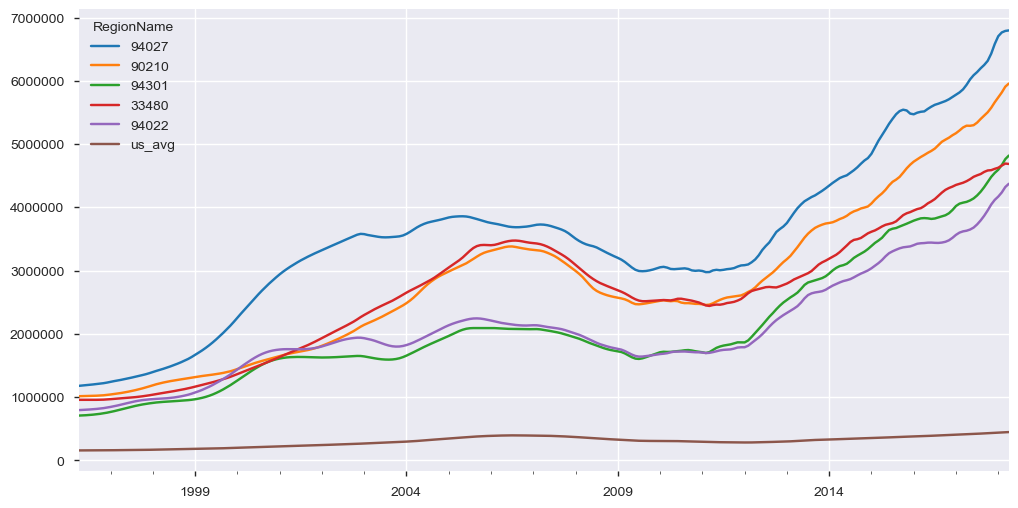

In [155]:
z_df[['94027', '90210', '94301', '33480', '94022', 'us_avg']].plot(figsize =(12, 6));

In [27]:
# rename columns 'ds' and 'y'(as required for fbprophet)
for zc in (zcs):
    zc.index.names = ['ds']
    zc.columns = ['y']
    #zc.reset_index(inplace=True)

In [28]:
## make data stationary with log and double differencing(not needed for auto_arima models)
# for zc in zcs:
#     #zc.y = np.log(zc.y)
#     zc.y = zc.y.diff().diff()
#     zc.dropna(inplace=True)

# visuals/modeling

## zip code: 94027

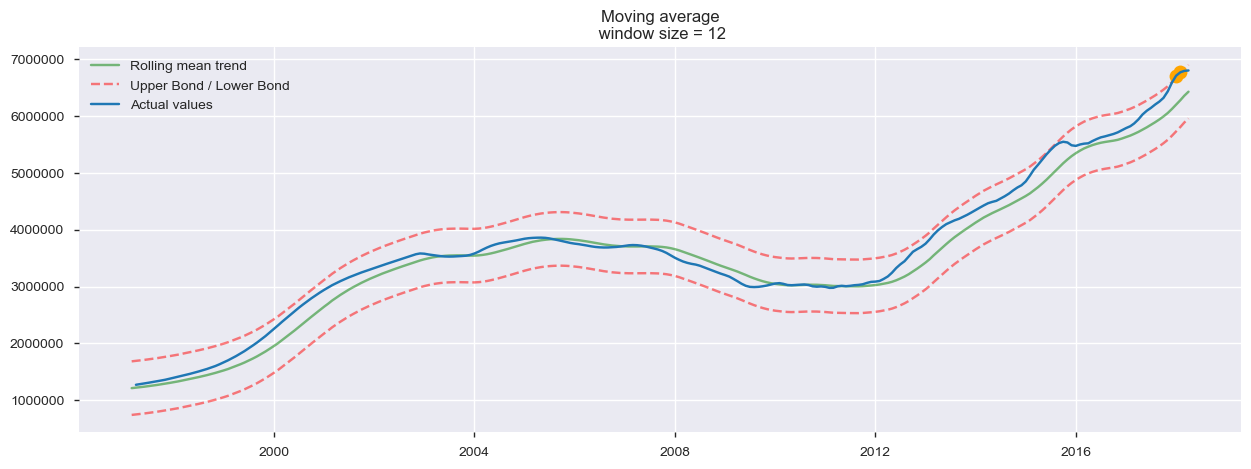

In [29]:
plotMovingAverage(z_df[['94027']], 12)

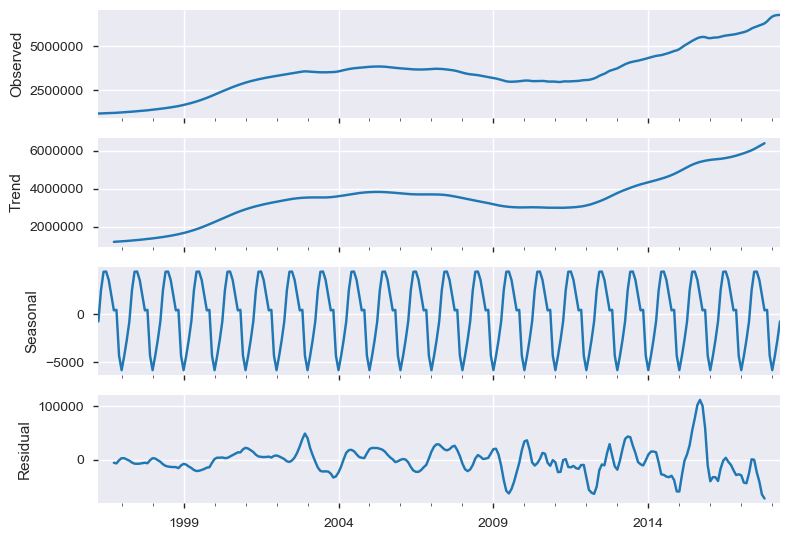

In [30]:
result = seasonal_decompose(z_df['94027'])
fig = result.plot()

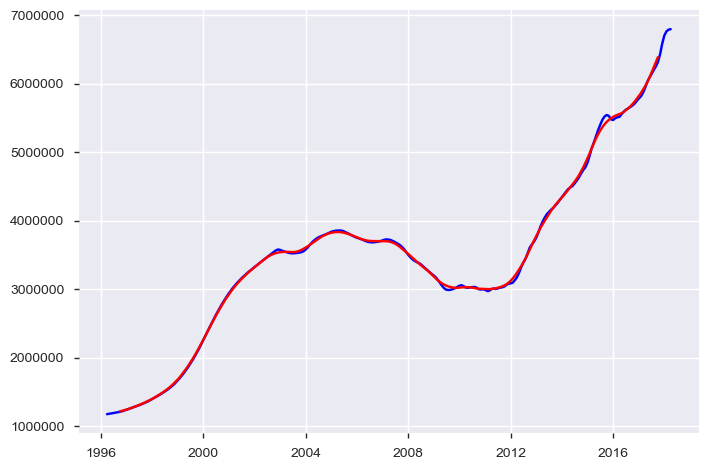

In [31]:
trend(z_df['94027'])

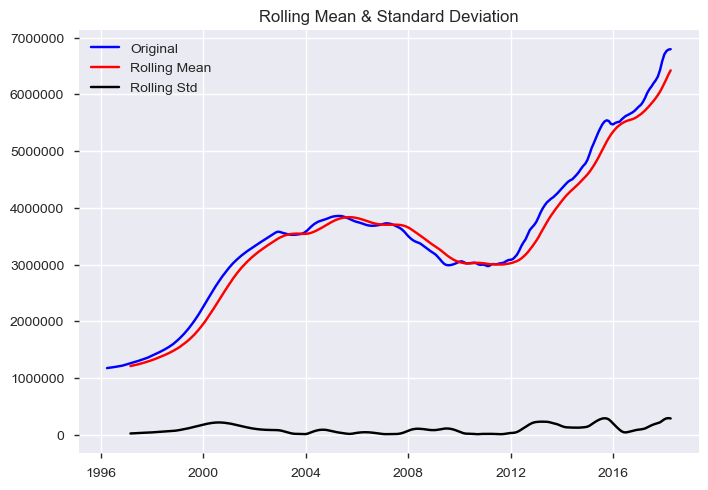

p-value: 0.882794
timeseries is not stationary


In [132]:
test_stationarity(zip_1.y)

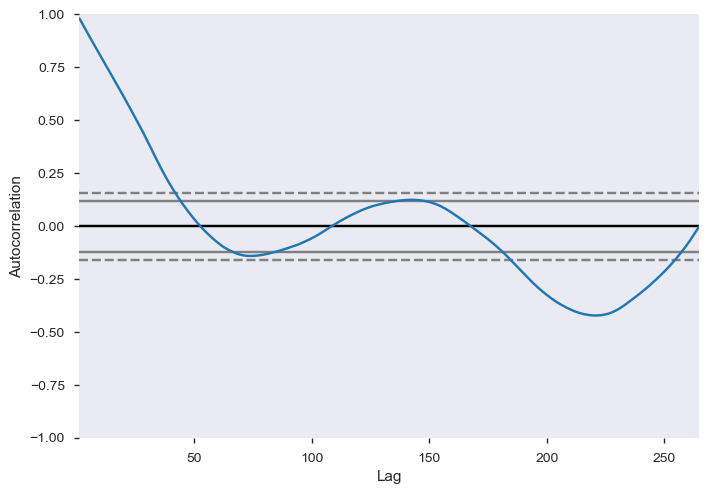

In [133]:
autocorrelation_plot(zip_1.y);

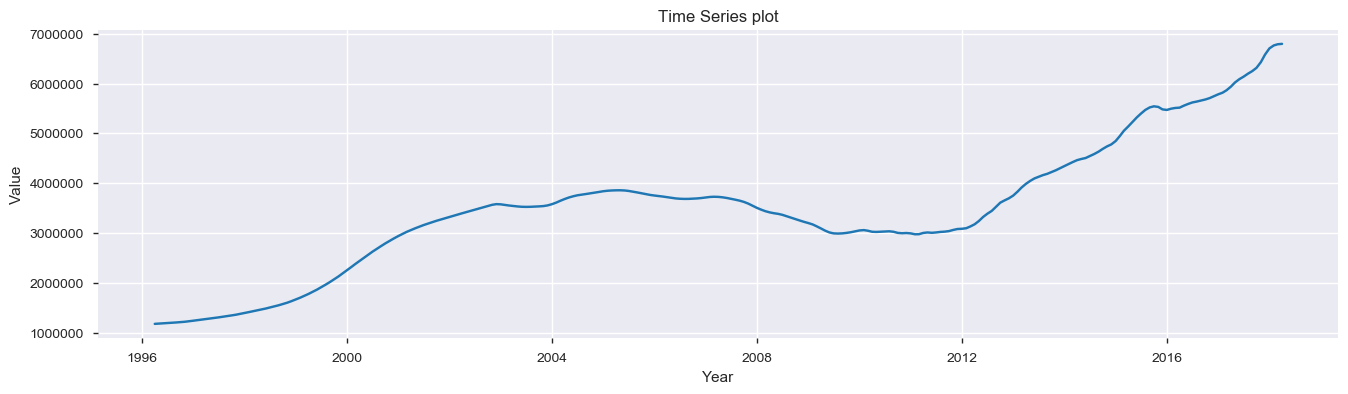

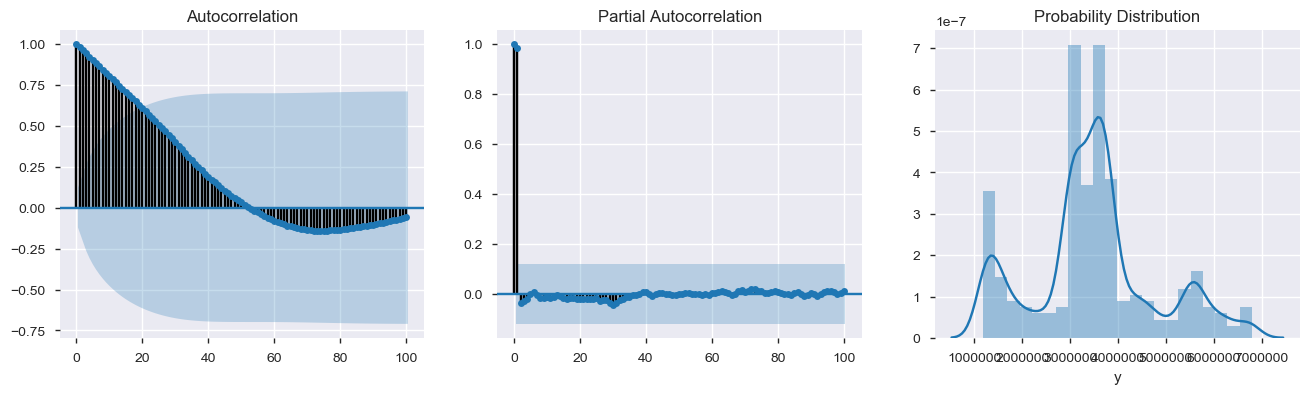

In [35]:
plot_data_properties(zip_1.y, 100)

## (s)ARIMA MODELING

## ignore

In [36]:
#get_arima(z_df['94027'])

In [37]:
#best_pdq(z_df['94027'])

In [38]:
# mod = sm.tsa.statespace.SARIMAX(zip_1,
#                                 order=(1, 1, 1),
#                                 seasonal_order=(1, 1, 1, 12),
#                                 enforce_stationarity=False,
#                                 enforce_invertibility=False)
# results = mod.fit()
# print(results.summary().tables[1])

In [39]:
#pm.auto_arima(zip_1)

In [40]:
# results.plot_diagnostics(figsize = (18,8));
# plt.show();

In [ ]:
# train = zip_1[:int(0.85*(len(zip_1)))]
# test = zip_1[int(0.85*(len(zip_1))):]

In [ ]:
# #building the model

# # auto_arima to find best fit for p,d,qs
# mod = pm.auto_arima(zip_1)

# # or use previous model
# results = mod.fit(train)

# forecast = results.predict(n_periods=len(test))
# forecast = pd.DataFrame(forecast,index = test.index,columns=['ds'])

# #plot the predictions for validation set
# plt.plot(train, label='Train')
# plt.plot(test, label='Valid')
# plt.plot(forecast, label='Prediction')
# plt.show();

In [ ]:
## one step ahead forecast: not good model
# pred = results.get_prediction(start=pd.to_datetime('2018'), dynamic=True)
# pred_ci = pred.conf_int()
# ax = zip_1['1996':].plot(label='observed')
# pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)
# ax.set_xlabel('date')
# ax.set_ylabel('value')
# plt.legend()
# plt.show();

In [ ]:
# def plotarima(n_periods, ts, automodel):
#     #forecast
#     fc, confint = automodel.predict(n_periods=n_periods, return_conf_int=True)
#     fc_ind= pd.date_range(ts.index[ts.shape[0]-1], periods=n_periods, freq='M')
#     fc_series = pd.Series(fc, index=fc_ind)
    
#     lower_series= pd.Series(confint[:, 0], index=fc_ind)
#     upper_series = pd.Series(confint[:, 1], index=fc_ind)
    
#     plt.figure(figsize=(10,6))
#     plt.plot(ts)
#     plt.plot(fc_series, color='red')
#     plt.y_label('timeseries')
#     plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.25)
#     plt.legend(('past', 'forecast', '95 confidence interval'), loc='upper left')
#     plt.show();
    

In [ ]:
#plotarima(12, z_df['94027'], mod)

In [ ]:
# pred = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=True)
# pred_conf = pred.conf_int()

In [ ]:
# pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
# pred_dynamic_conf = pred_dynamic.conf_int()

## zip 94027

In [134]:
#test_stationarity(zip_1.y)

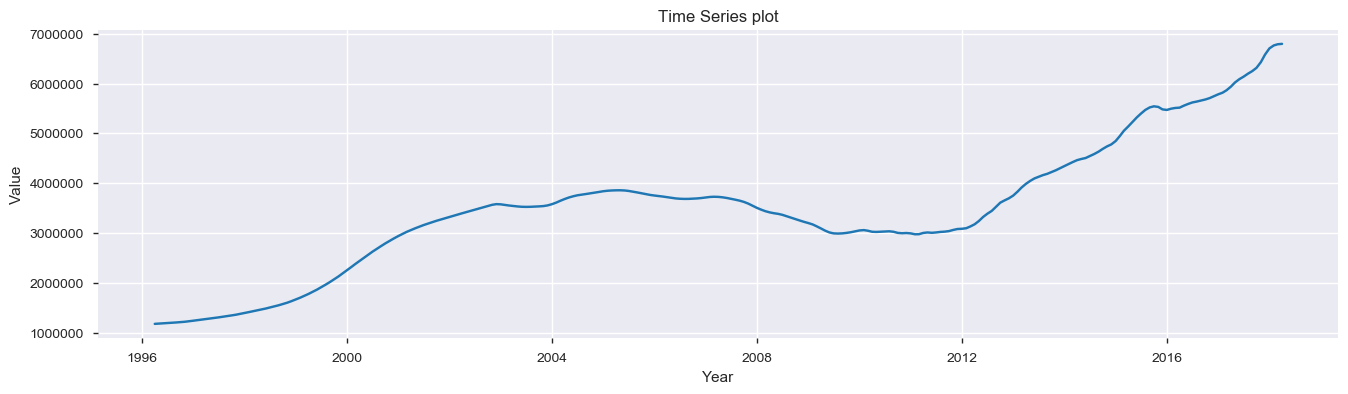

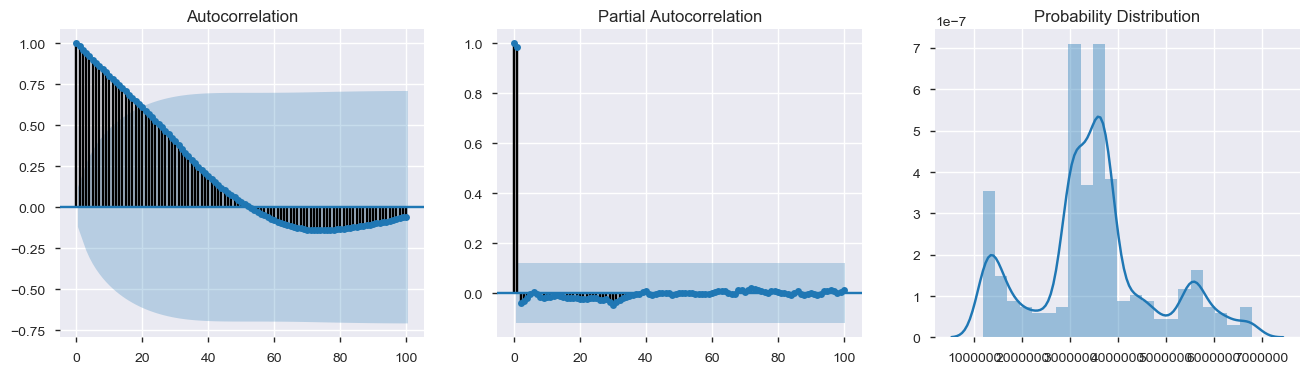

In [136]:
plot_data_properties(zip_1, 100)

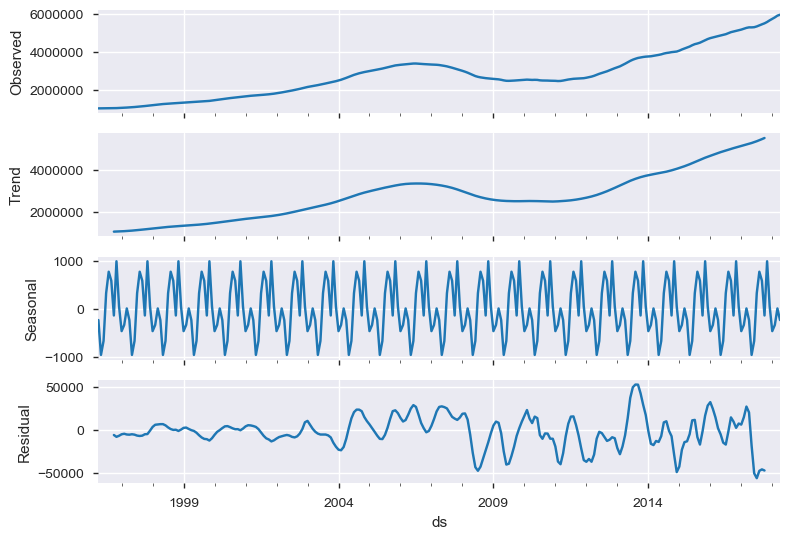

In [138]:
seas_decomp(zip_1)

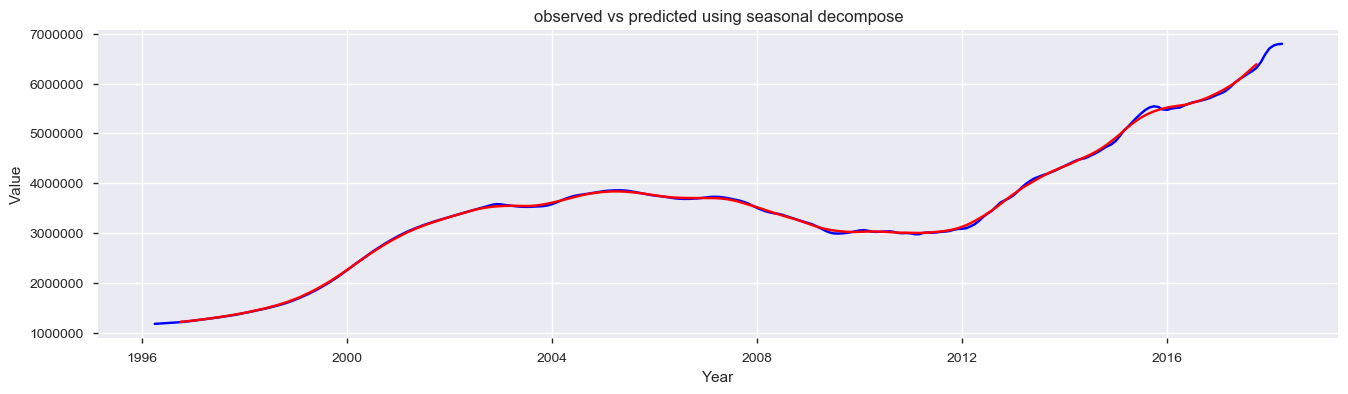

In [143]:
trend(zip_1)

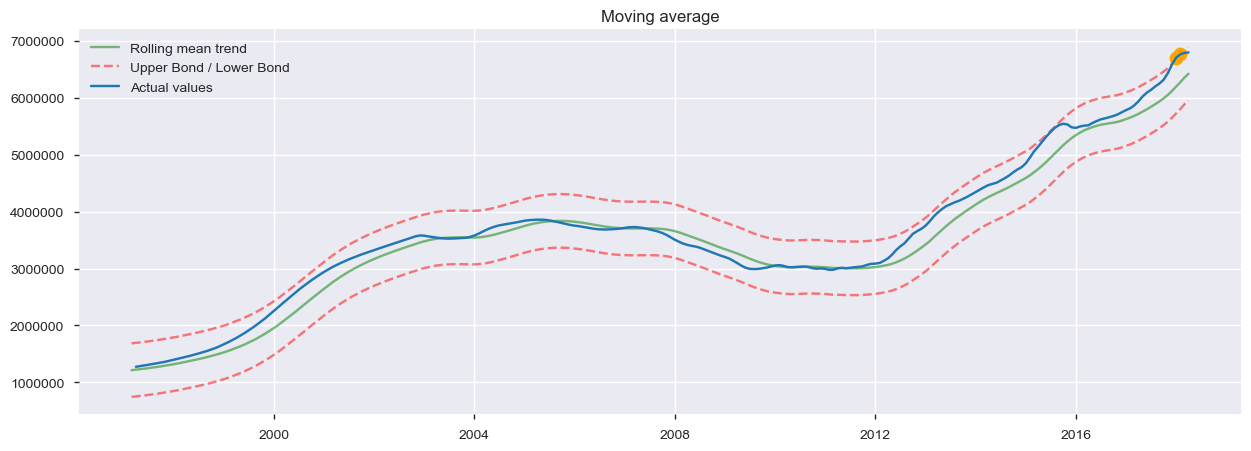

In [149]:
plot_moving_avg(zip_1)

## zip 90210

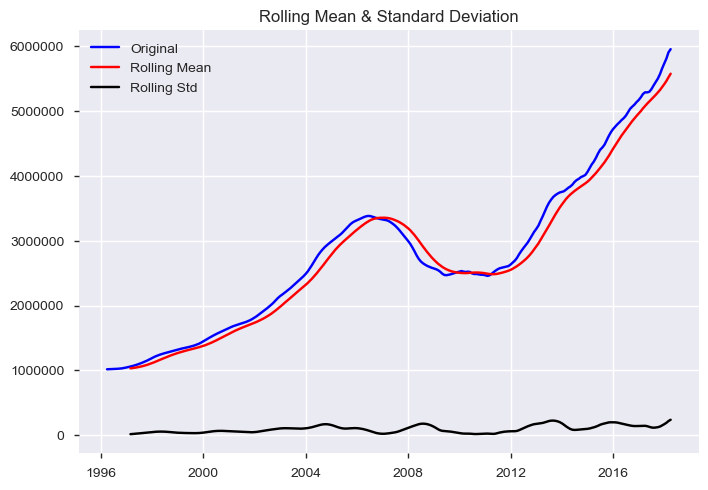

p-value: 0.983663
timeseries is not stationary


In [127]:
#test_stationarity(zip_2.y)

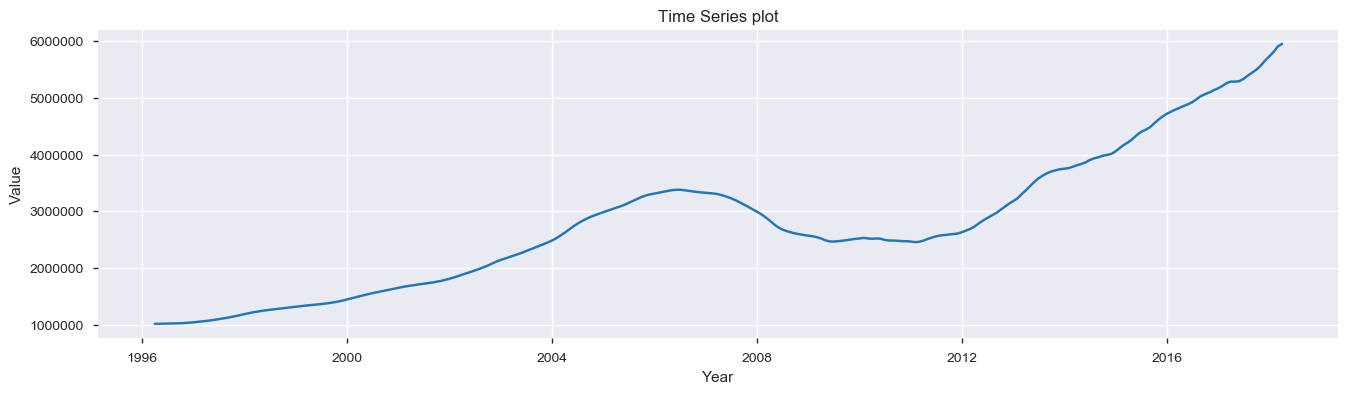

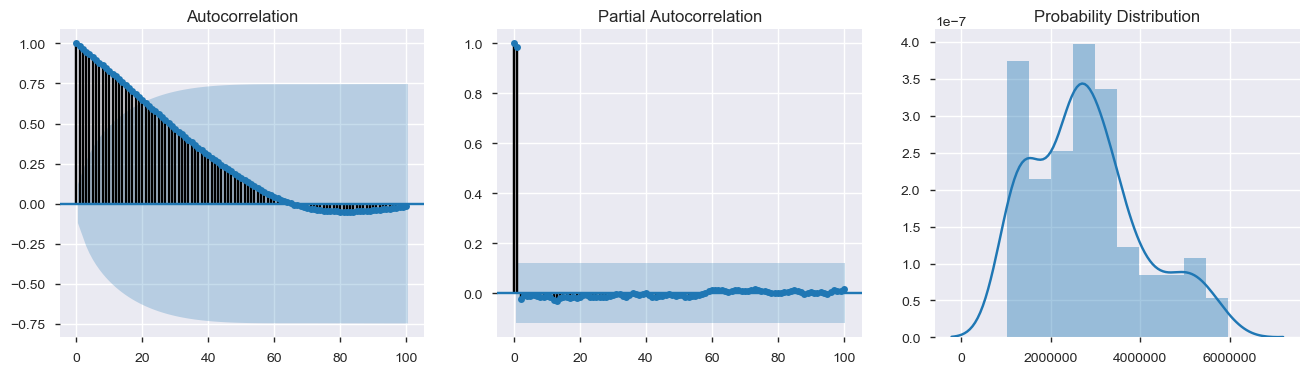

In [53]:
plot_data_properties(zip_2, 100)

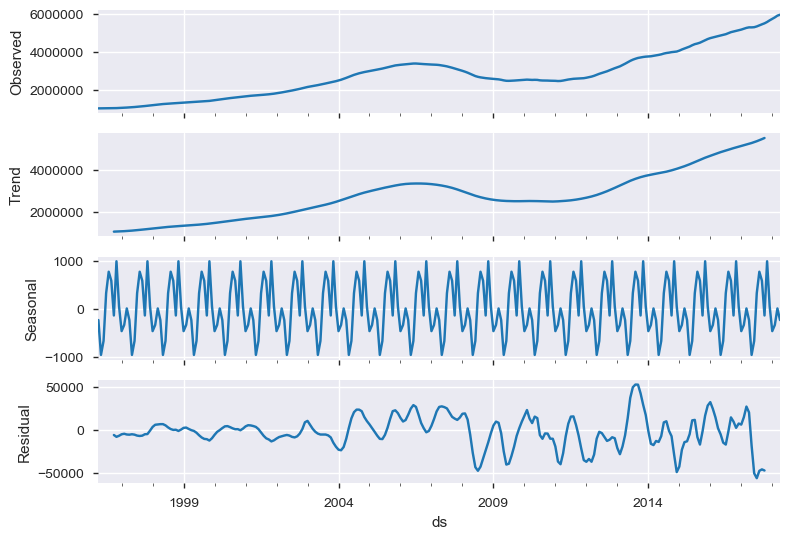

In [92]:
seas_decomp(zip_2)

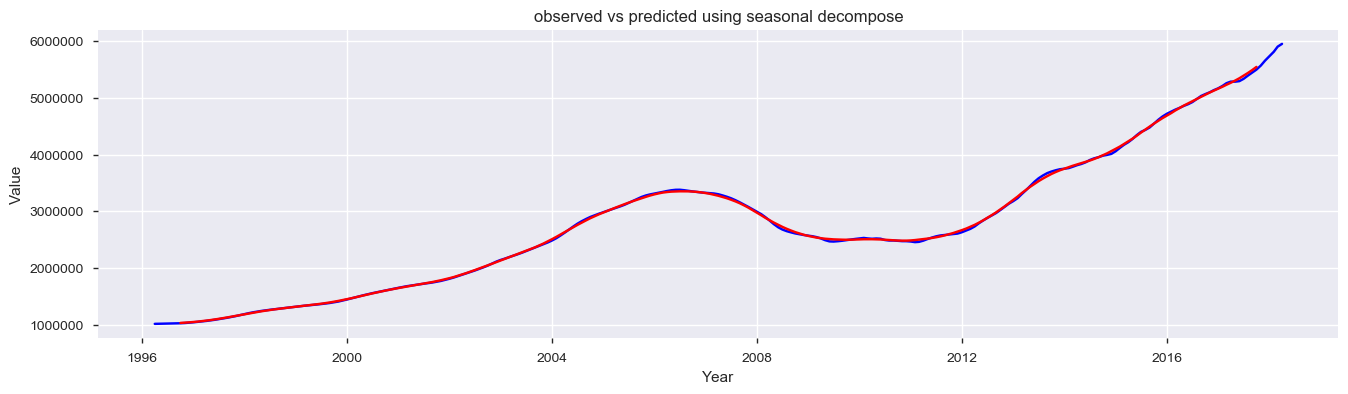

In [142]:
trend(zip_2)

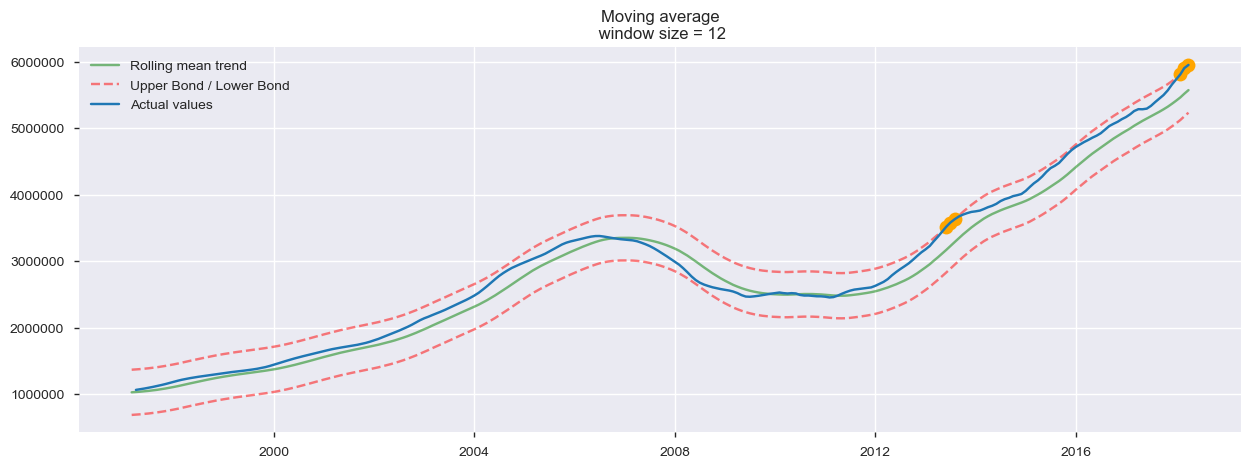

In [114]:
plotMovingAverage(zip_2, 12, scale = 1.5)

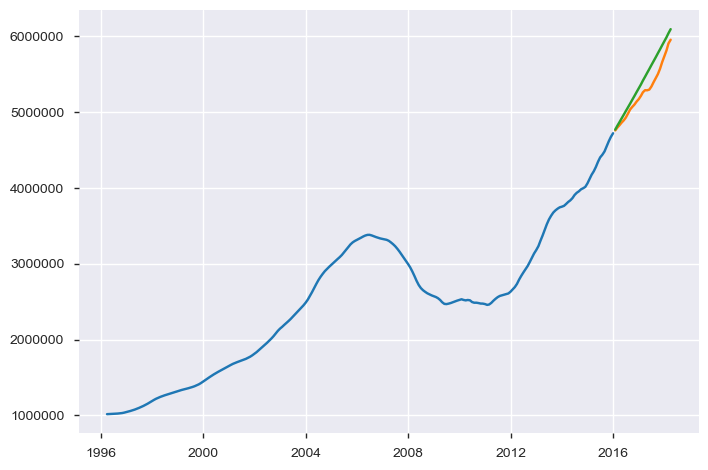

square root mean error: 174740
MSE percent: 0.0
explained variance score: 1.0


In [106]:
auto_sarima(zip_2, 0.90)

## zip 94301

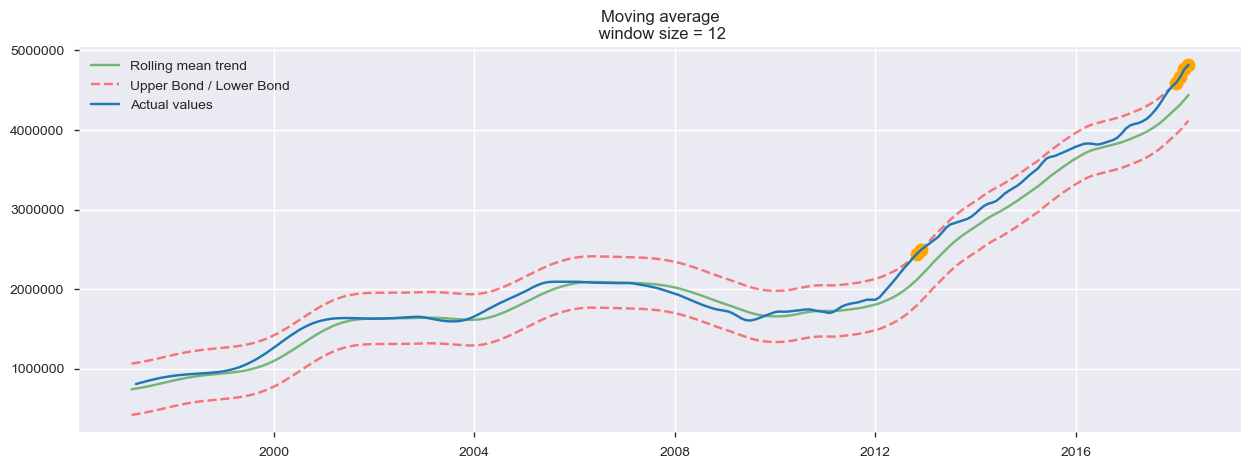

In [91]:
plotMovingAverage(zip_3, 12)

/Users/Janelle/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


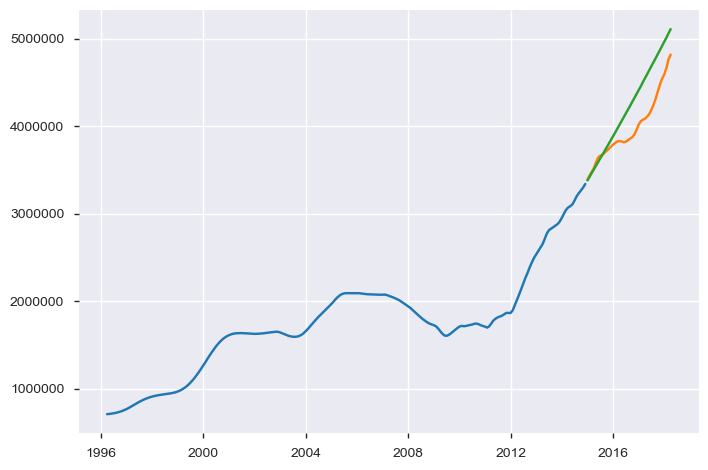

square root mean error: 312985.61484123283
MSE percent: 5.749517427557545
explained variance score: 0.864273214176556


In [108]:
auto_sarima(zip_3, .85)

## zip 33480

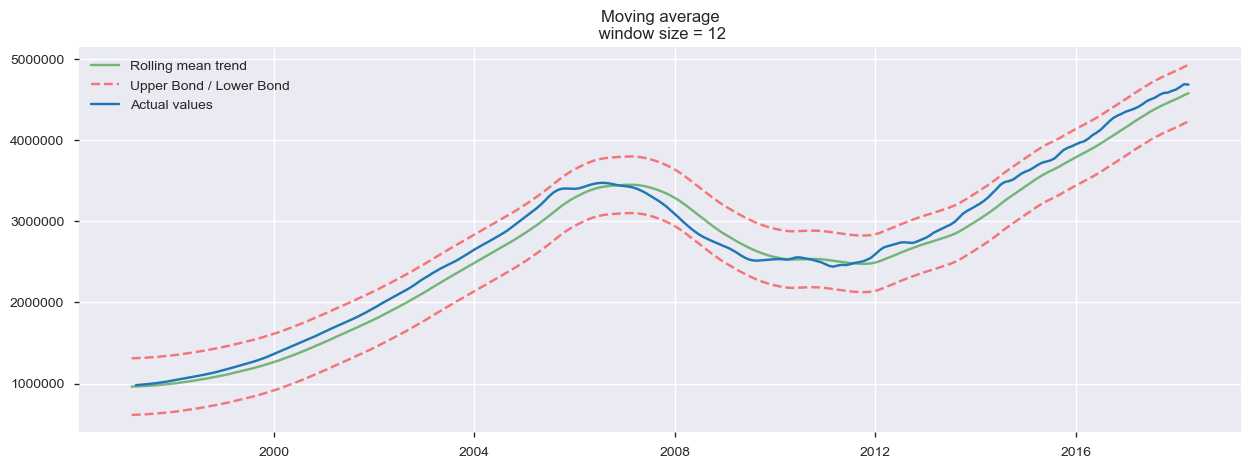

In [67]:
plotMovingAverage(zip_4, 12)

/Users/Janelle/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Janelle/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Janelle/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Janelle/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Janelle/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimizat

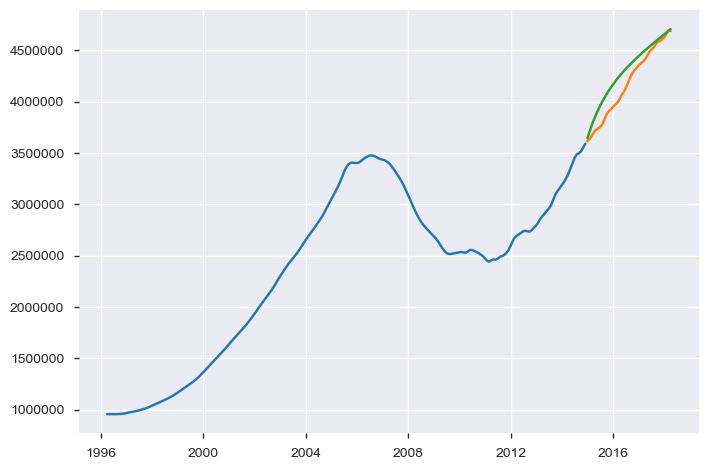

140326.76202877067
2.8245743087469566
0.9325866768712903


In [48]:
auto_sarima(zip_4, .85)

## zip 94022

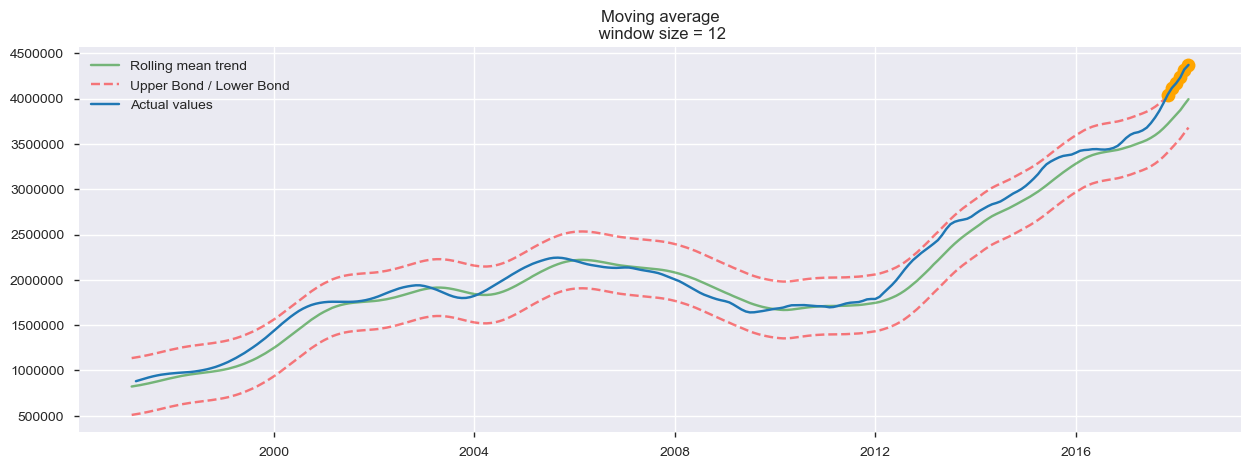

In [81]:
plotMovingAverage(zip_5, 12)

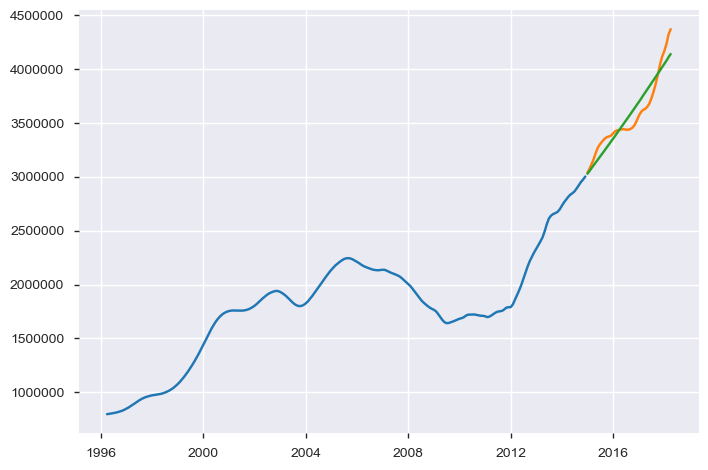

112552.92138799584
2.6917616386131207
0.8832640050054901


In [50]:
auto_sarima(zip_5, .85)

# fbprophet

In [ ]:
import fbprophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

In [ ]:
fb_1 = zip_1.reset_index()

In [ ]:
m = fbprophet.Prophet(interval_width=0.95)
m.fit(fb_1)
future = m.make_future_dataframe(periods=24, freq='MS')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail().round()

In [ ]:
df_cv = cross_validation(m, horizon='90 days')
df_p = performance_metrics(df_cv)

In [ ]:
m.plot(forecast, uncertainty=True)
plt.show();

In [ ]:
m.plot_components(forecast);

In [ ]:
plot_plotly(m, forecast)
py.iplot(fig);

In [ ]:
fig3 = plot_cross_validation_metric(df_cv, metric='mape')

In [ ]:
# # setting initial values and some bounds for them
# ps = range(2, 5)
# d=2 
# qs = range(2, 5)
# Ps = range(0, 2)
# D=2 
# Qs = range(0, 2)
# s = 12

# # creating list with all the possible combinations of parameters
# parameters = product(ps, qs, Ps, Qs)
# parameters_list = list(parameters)
# len(parameters_list)

# def optimizeSARIMA(df, parameters_list, d, D, s):
#     """
#         Return dataframe with parameters and corresponding AIC
        
#         parameters_list - list with (p, q, P, Q) tuples
#         d - integration order in ARIMA model
#         D - seasonal integration order 
#         s - length of season
#     """
    
#     results = []
#     best_aic = float("inf")

#     for param in tqdm_notebook(parameters_list):
#         # we need try-except because on some combinations model fails to converge
#         try:
#             model=sm.tsa.statespace.SARIMAX(df.y, order=(param[0], d, param[1]), 
#                                             seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
#         except:
#             continue
#         aic = model.aic
#         # saving best model, AIC and parameters
#         if aic < best_aic:
#             best_model = model
#             best_aic = aic
#             best_param = param
#         results.append([param, model.aic])

#     result_table = pd.DataFrame(results)
#     result_table.columns = ['parameters', 'aic']
#     # sorting in ascending order, the lower AIC is - the better
#     result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
#     return result_table

# result_table = optimizeSARIMA(zip_1, parameters_list, d, D, s)
# result_table.head()

# pred = results.get_prediction(start=pd.to_datetime('2017'), dynamic=False)
# pred_ci = pred.conf_int()
# ax = zip_1.y['1996':].plot(label='observed')
# pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)
# ax.set_xlabel('Date')
# ax.set_ylabel('Retail_sold')
# plt.legend()
# plt.show()

# # set the parameters that give the lowest AIC
# p, q, P, Q = result_table.parameters[0]

# best_model=sm.tsa.statespace.SARIMAX(zip_1.y, order=(p, d, q), 
#                                         seasonal_order=(P, D, Q, s)).fit(disp=-1)
# print(best_model.summary())

# results = best_model.fit()
# results.plot_diagnostics();
# plt.show()

# def plotSARIMA(series, model, n_steps):
#     """
#         Plots model vs predicted values
        
#         series - dataset with timeseries
#         model - fitted SARIMA model
#         n_steps - number of steps to predict in the future
        
#     """
#     # adding model values
#     data = series.copy()
#     data.y = ['actual']
#     data['arima_model'] = model.fittedvalues
#     # making a shift on s+d steps, because these values were unobserved by the model
#     # due to the differentiating
#     data['arima_model'][:s+d] = np.NaN
    
#     # forecasting on n_steps forward 
#     forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
#     forecast = data.arima_model.append(forecast)
#     # calculate error, again having shifted on s+d steps from the beginning
#     error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

#     plt.figure(figsize=(15, 7))
#     plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
#     plt.plot(forecast, color='r', label="model")
#     plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
#     plt.plot(data.actual, label="actual")
#     plt.legend()
#     plt.grid(True);

# plotSARIMA(zip_1, best_model, 24)